# Baseline Model (NGBoost)
Penelitian "PENERAPAN MACHINE LEARNING UNTUK ESTIMASI REMAINING USEFUL LIFE (RUL) ROLLER PADA TOP WEIGHTING ARM MESIN RING SPINNING (STUDI KASUS PT. XYZ)" - Hanindita Jati (2025)

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from ngboost import NGBRegressor
from ngboost.distns import Normal
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import *

from scipy.stats import norm

from sklearn.linear_model import LinearRegression

In [2]:
# Baca Data
data = pd.read_excel('DATAMODEL_2.xlsx', sheet_name='Sheet4x3') # pake data yg ada outlier jelas di excel
data = data.drop(columns=['ipi', 'ap']) # kolom rsf (udah bener tapi masi v1) dan ap belum bener, jadi diabaikan dulu
print(f'data.shape : {data.shape}\n')
print(data.info())
data.head(2)

data.shape : (447, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    447 non-null    datetime64[ns]
 1   RSF     447 non-null    object        
 2   ne      447 non-null    int64         
 3   u       447 non-null    float64       
 4   cvm     447 non-null    float64       
 5   cv1m    447 non-null    float64       
 6   thin    447 non-null    int64         
 7   thick   447 non-null    int64         
 8   neps    447 non-null    int64         
 9   ha      447 non-null    float64       
 10  D1      447 non-null    float64       
 11  D2      447 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 42.0+ KB
None


,Date,RSF,ne,u,cvm,cv1m,thin,thick,neps,ha,D1,D2
0,2024-02-01,1C,28,8.82,11.09,3.31,0,2,2,3.87,30.0,28.5
1,2024-02-01,1D,40,9.85,12.42,4.80,0,8,10,4.12,30.0,28.5


## Pola Degradasi Roller

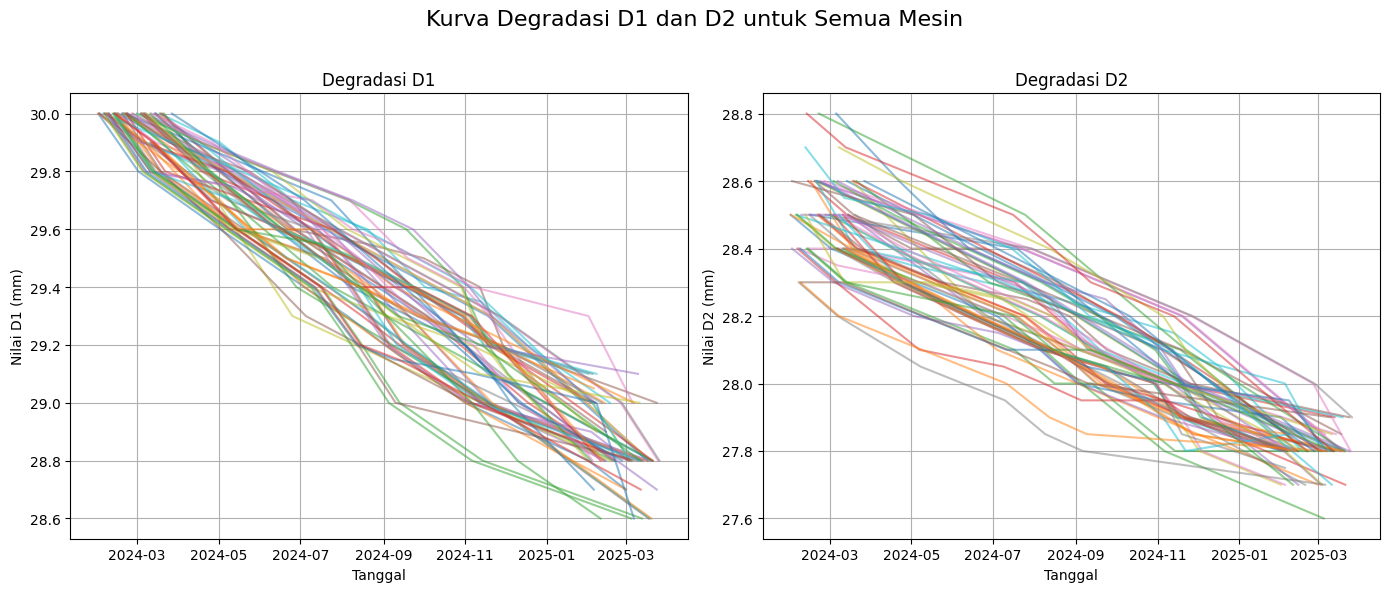

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for key, group in data.groupby('RSF'):
    axs[0].plot(group['Date'], group['D1'], alpha=0.5)
axs[0].set_title('Degradasi D1')
axs[0].set_xlabel('Tanggal')
axs[0].set_ylabel('Nilai D1 (mm)')
axs[0].grid(True)

for key, group in data.groupby('RSF'):
    axs[1].plot(group['Date'], group['D2'], alpha=0.5)
axs[1].set_title('Degradasi D2')
axs[1].set_xlabel('Tanggal')
axs[1].set_ylabel('Nilai D2 (mm)')
axs[1].grid(True)

# Judul keseluruhan
fig.suptitle('Kurva Degradasi D1 dan D2 untuk Semua Mesin', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Menambah kolom elapsed_days dan RUL
Untuk mengetahui berapa hari berlalu sejak hari pertama serta mengetahui berapa hari tersisa sejak penggantian roller (D1, D2) untuk setiap mesin (RSF).

In [4]:
data['elapsed_days'] = data.groupby('RSF')['Date'].transform(lambda x: (x - x.min()).dt.days)
#data['RUL'] = data.groupby('RSF')['elapsed_days'].transform('max') - data['elapsed_days']

data

,Date,RSF,ne,u,cvm,cv1m,thin,thick,neps,ha,D1,D2,elapsed_days
0,2024-02-01,1C,28,8.82,11.09,3.31,0,2,2,3.87,30.0,28.5,0
1,2024-02-01,1D,40,9.85,12.42,4.80,0,8,10,4.12,30.0,28.5,0
2,2024-02-02,2C,28,8.83,11.08,3.58,0,2,3,3.94,30.0,28.4,0
3,2024-02-02,2D,40,9.86,12.48,4.04,0,7,11,3.58,30.0,28.6,0
4,2024-02-05,3C,28,8.92,11.21,3.57,0,2,2,4.02,30.0,28.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,2025-03-21,16C,40,10.86,13.63,4.51,7,6,8,4.01,28.8,27.8,393
443,2025-03-24,17D,30,10.59,13.50,3.67,0,6,8,3.83,29.0,27.9,395
444,2025-03-24,17C,40,10.85,13.65,4.20,4,4,9,4.04,28.7,27.8,395
445,2025-03-25,18C,40,11.00,13.87,3.73,3,12,7,4.22,28.8,27.8,393


## NGBoost (Baseline Model)

NGBoost cocok untuk:
- Prediksi regresi dengan ketidakpastian (uncertainty).
- Estimasi distribusi penuh (bukan hanya nilai prediksi tunggal), seperti kapan D1 atau D2 menyentuh ambang batas.

Referensi:
- Duan, T., Avati, A., Xiao, L., Wood, F., & Ng, A. (2020). NGBoost: Natural Gradient Boosting for Probabilistic Prediction. https://doi.org/10.48550/arXiv.1910.03225

In [5]:
target_cols = ['D1', 'D2']

X_full = data.drop(columns=target_cols)  # Tetap simpan RSF dan elapsed_days
y = data[target_cols]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

numerical_features = data.select_dtypes(include='number').columns.tolist()
exclude_cols = ['D1', 'D2']
features = [col for col in numerical_features if col not in exclude_cols]

X_train = X_train_raw[features]
X_test = X_test_raw[features]

In [6]:
ngb_d1 = NGBRegressor(Dist=Normal, verbose=False)
ngb_d2 = NGBRegressor(Dist=Normal, verbose=False)

ngb_d1.fit(X_train, y_train['D1'])
ngb_d2.fit(X_train, y_train['D2'])

,Dist,<class 'ngboo...ormal.Normal'>
,Score,<class 'ngboo...res.LogScore'>
,Base,"DecisionTreeR..., max_depth=3)"
,natural_gradient,True
,n_estimators,500
,learning_rate,0.01
,minibatch_frac,1.0
,col_sample,1.0
,verbose,False
,random_state,RandomState(M... 0x26D2AA91C40
,validation_fraction,0.1


## Metrik Evaluasi Model

Metrik evaluasi model regresi yang digunakan adalah:


#### 1. Root Mean Squared Error (RMSE)

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

#### 2. Mean Absolute Error (MAE)

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

#### 3. Mean Absolute Percentage Error (MAPE)

$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

#### 4. Coefficient of Determination (R² Score)

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

Keterangan:

$$
\begin{align*}
y_i &= \text{nilai aktual ke-}i \\
\hat{y}_i &= \text{nilai prediksi ke-}i \\
\bar{y} &= \text{rata-rata dari seluruh } y_i \\
n &= \text{jumlah sampel}
\end{align*}
$$


In [7]:
# Evaluasi model
y_pred_d1 = ngb_d1.predict(X_test)
y_pred_d2 = ngb_d2.predict(X_test)

y_true_d1 = y_test['D1'].values
y_true_d2 = y_test['D2'].values

# D1
rmse_d1 = np.sqrt(mean_squared_error(y_true_d1, y_pred_d1))
mae_d1 = mean_absolute_error(y_true_d1, y_pred_d1)
mape_d1 = mean_absolute_percentage_error(y_true_d1, y_pred_d1)
r2_d1 = r2_score(y_true_d1, y_pred_d1)

# D2
rmse_d2 = np.sqrt(mean_squared_error(y_true_d2, y_pred_d2))
mae_d2 = mean_absolute_error(y_true_d2, y_pred_d2)
mape_d2 = mean_absolute_percentage_error(y_true_d2, y_pred_d2)
r2_d2 = r2_score(y_true_d2, y_pred_d2)

# Cetak hasil
print("RMSE untuk D1 dan D2:", [rmse_d1, rmse_d2])
print("MAE untuk D1 dan D2:", [mae_d1, mae_d2])
print("MAPE untuk D1 dan D2:", [mape_d1, mape_d2])
print("R2 score untuk D1 dan D2:", [r2_d1, r2_d2])

RMSE untuk D1 dan D2: [np.float64(0.09104001675559546), np.float64(0.07601781490788176)]
MAE untuk D1 dan D2: [0.06380557743259634, 0.06124422614084067]
MAPE untuk D1 dan D2: [0.002182635657257024, 0.002178155904612008]
R2 score untuk D1 dan D2: [0.9585130563491987, 0.924258424431967]


Interpretasi:

- RMSE & MAE rendah: Menunjukkan error pada prediksi sangat kecil. Untuk skala diameter (sekitar 28–30 mm), kesalahan <0.1 mm masih dalam toleransi proses QC industri tekstil (biasanya ±0.2 mm).

- MAPE < 1%: Tergolong bagus, menunjukkan model presisi dalam memprediksi. Umumnya, MAPE < 10% dianggap baik dalam konteks prediksi industri (Hyndman & Koehler, 2006).

- R² mendekati 1: Artinya >95% (D1) dan >92% (D2) variasi dalam data berhasil dijelaskan oleh model (Chicco dkk., 2021).

Referensi:

- Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688. https://doi.org/10.1016/j.ijforecast.2006.03.001

- Chicco, D., Warrens, M. J., & Jurman, G. (2021). The coefficient of determination R-squared is more informative than SMAPE, MAE, MAPE, MSE and RMSE in regression analysis evaluation. PeerJ Computer Science, 7, 1–24. https://doi.org/10.7717/PEERJ-CS.623

## Cross Validation

Cross-Validation (CV) diperlukan untuk mengukur kemampuan generalisasi model ke data baru yang tidak pernah dilihat saat pelatihan dengan membagi data menjadi beberapa fold (Koul, Becchio, & Cavallo, 2018)

CV dapat mengurangi risiko overfitting dan underfitting (Koul et al, 2018).

Fold yang digunakan pada CV sebanyak 5-fold, agar dapat memberikan estimasi performa yang akurat dengan beban komputasi yang rendah (López, Fernández, García, Palade, & Herrera, 2013).


Referensi:
- Koul, A., Becchio, C., & Cavallo, A. (2018). Cross-validation approaches for replicability in psychology. Frontiers in Psychology, 9, 1117.
https://doi.org/10.3389/fpsyg.2018.01117
- López, V., Fernández, A., García, S., Palade, V., & Herrera, F. (2013). An insight into classification with imbalanced data: Empirical results and current trends on using data intrinsic characteristics. Information Sciences, 250, 113–141.
https://doi.org/10.1016/j.ins.2013.07.007

In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores, mae_scores, mape_scores, r2_scores = [], [], [], []

for train_idx, val_idx in kf.split(X_full):
    X_train_fold = X_full.iloc[train_idx][features]
    X_val_fold = X_full.iloc[val_idx][features]
    
    y_train_d1_fold = y.iloc[train_idx]['D1']
    y_val_d1_fold = y.iloc[val_idx]['D1']
    y_train_d2_fold = y.iloc[train_idx]['D2']
    y_val_d2_fold = y.iloc[val_idx]['D2']
    
    cv_ngb_d1 = NGBRegressor(Dist=Normal, verbose=False)
    cv_ngb_d2 = NGBRegressor(Dist=Normal, verbose=False)

    cv_ngb_d1.fit(X_train_fold, y_train_d1_fold)
    cv_ngb_d2.fit(X_train_fold, y_train_d2_fold)

    y_pred_d1_fold = cv_ngb_d1.predict(X_val_fold)
    y_pred_d2_fold = cv_ngb_d2.predict(X_val_fold)

    rmse = [np.sqrt(mean_squared_error(y_val_d1_fold, y_pred_d1_fold)),
            np.sqrt(mean_squared_error(y_val_d2_fold, y_pred_d2_fold))]
    
    mae = [mean_absolute_error(y_val_d1_fold, y_pred_d1_fold),
           mean_absolute_error(y_val_d2_fold, y_pred_d2_fold)]

    mape = [mean_absolute_percentage_error(y_val_d1_fold, y_pred_d1_fold),
            mean_absolute_percentage_error(y_val_d2_fold, y_pred_d2_fold)]

    r2 = [r2_score(y_val_d1_fold, y_pred_d1_fold),
          r2_score(y_val_d2_fold, y_pred_d2_fold)]

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)
    r2_scores.append(r2)

In [9]:
rmse_scores = np.array(rmse_scores)
mae_scores = np.array(mae_scores)
mape_scores = np.array(mape_scores)
r2_scores = np.array(r2_scores)

# Tampilkan hasil
metrics = {'RMSE': rmse_scores, 'MAE': mae_scores, 'MAPE': mape_scores, 'R2': r2_scores}
target_names = ['D1', 'D2']

for i, target in enumerate(target_names):
    print(f"\n=== Cross-Validation {target} ===")
    for metric_name, scores in metrics.items():
        values = scores[:, i]
        average = np.mean(values)
        formatted_values = " ".join([f"{v:.8f}" for v in values])
        print(f"{metric_name} Scores: [{formatted_values}]")
        print(f"Average {metric_name}: {average:.4f}")


=== Cross-Validation D1 ===
RMSE Scores: [0.09101720 0.10068853 0.10277299 0.11181926 0.12896396]
Average RMSE: 0.1071
MAE Scores: [0.06398922 0.07830895 0.07351962 0.07838280 0.09804812]
Average MAE: 0.0784
MAPE Scores: [0.00218896 0.00266520 0.00250840 0.00267236 0.00334918]
Average MAPE: 0.0027
R2 Scores: [0.95853385 0.92983959 0.91646434 0.91185304 0.88319963]
Average R2: 0.9200

=== Cross-Validation D2 ===
RMSE Scores: [0.07627955 0.07728985 0.09880281 0.08978650 0.08022643]
Average RMSE: 0.0845
MAE Scores: [0.06140994 0.05742544 0.07314776 0.07206724 0.05910533]
Average MAE: 0.0646
MAPE Scores: [0.00218411 0.00203611 0.00259410 0.00255377 0.00209860]
Average MAPE: 0.0023
R2 Scores: [0.92373596 0.90371869 0.84549416 0.85938970 0.88133977]
Average R2: 0.8827


Interpretasi:
- Model Baseline NGBoost dengan multi-output mampu memprediksi degradasi roller (D1, D2) secara akurat dan stabil.
- CV memperlihatkan performa konsisten antar fold, yang berarti bahwa model dapat diandalkan pada data baru.

## Hasil Prediksi banding Aktual

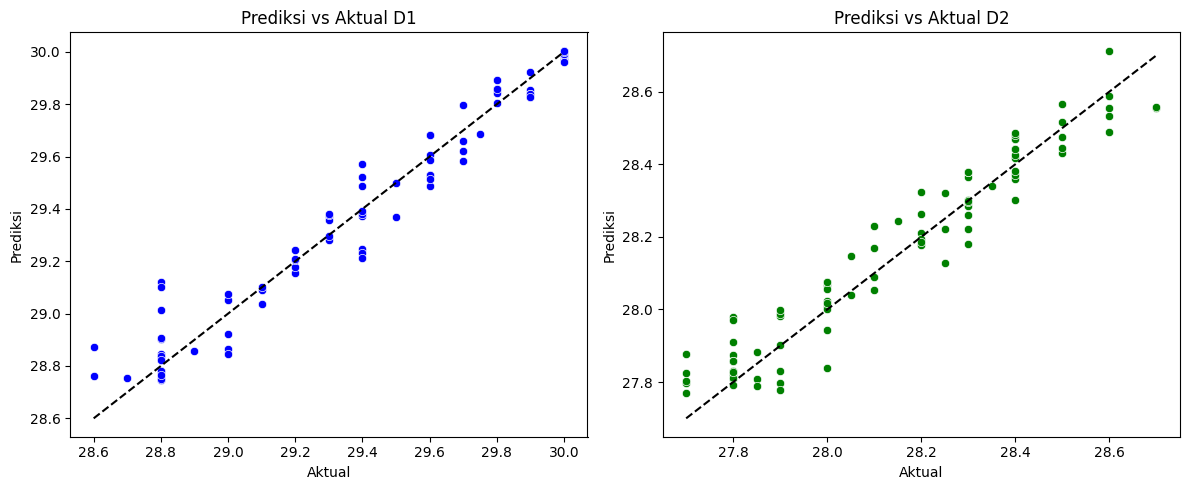

In [10]:
y_true_d1 = y_test['D1'].to_numpy()
y_true_d2 = y_test['D2'].to_numpy()
y_pred_d1 = y_pred_d1
y_pred_d2 = y_pred_d2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# D1
sns.scatterplot(x=y_true_d1, y=y_pred_d1, ax=axes[0], color='blue')
axes[0].plot([y_true_d1.min(), y_true_d1.max()],
             [y_true_d1.min(), y_true_d1.max()], 'k--')
axes[0].set_title('Prediksi vs Aktual D1')
axes[0].set_xlabel('Aktual')
axes[0].set_ylabel('Prediksi')

# D2
sns.scatterplot(x=y_true_d2, y=y_pred_d2, ax=axes[1], color='green')
axes[1].plot([y_true_d2.min(), y_true_d2.max()],
             [y_true_d2.min(), y_true_d2.max()], 'k--')
axes[1].set_title('Prediksi vs Aktual D2')
axes[1].set_xlabel('Aktual')
axes[1].set_ylabel('Prediksi')

plt.tight_layout()
plt.show()

Interpretasi:

- Kedua grafik menunjukkan bahwa model regresi yang digunakan dapat memprediksi D1 dan D2 dengan baik.

- Distribusi titik yang mendekati garis diagonal menunjukkan bahwa tidak terdapat pola kesalahan yang konsisten. Hal ini menandakan model tidak bias.

- Performa model sedikit lebih baik untuk D1 dibandingkan D2, meskipun keduanya berada pada tingkat akurasi tinggi (R² > 0.9).

- Visualisasi ini bersama dengan hasil metrik evaluasi menunjukkan bahwa **baseline model NGBoost** telah berhasil melakukan prediksi dengan presisi tinggi untuk kedua target (D1 dan D2), serta tidak menunjukkan adanya pola kesalahan sistematis.

Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688. https://doi.org/10.1016/j.ijforecast.2006.03.001

## Residual Plot

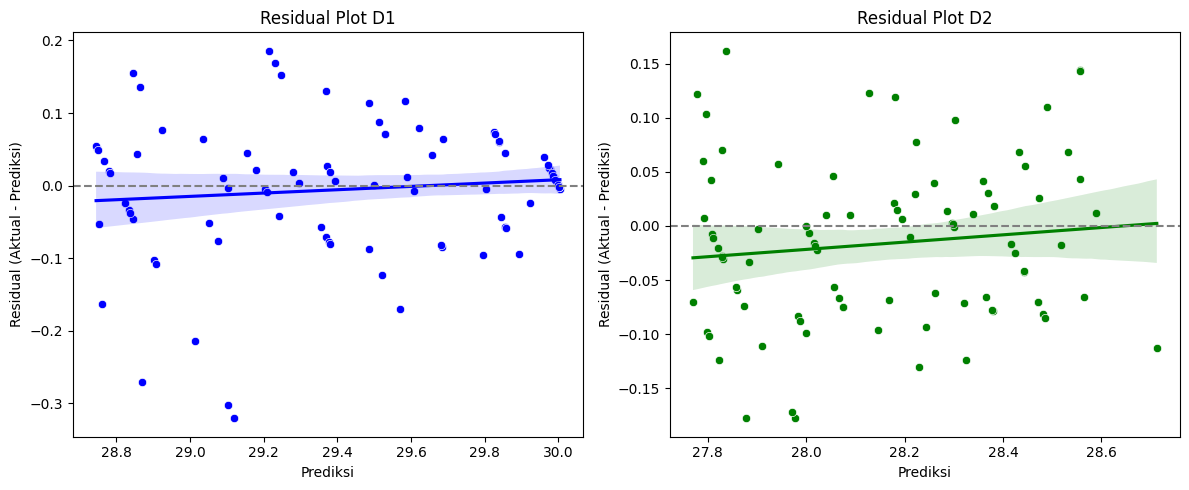

In [11]:
residuals_d1 = y_true_d1 - y_pred_d1
residuals_d2 = y_true_d2 - y_pred_d2

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residual D1
sns.scatterplot(x=y_pred_d1, y=residuals_d1, ax=axes[0], color='blue')
sns.regplot(x=y_pred_d1, y=residuals_d1, ax=axes[0], scatter=False, color='blue')
axes[0].axhline(0, linestyle='--', color='gray')
axes[0].set_title('Residual Plot D1')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Residual (Aktual - Prediksi)')

# Residual D2
sns.scatterplot(x=y_pred_d2, y=residuals_d2, ax=axes[1], color='green')
sns.regplot(x=y_pred_d2, y=residuals_d2, ax=axes[1], scatter=False, color='green')
axes[1].axhline(0, linestyle='--', color='gray')
axes[1].set_title('Residual Plot D2')
axes[1].set_xlabel('Prediksi')
axes[1].set_ylabel('Residual (Aktual - Prediksi)')

plt.tight_layout()
plt.show()

Berdasarkan plot prediksi vs aktual dan residual untuk D1 dan D2, model prediksi menunjukkan performa yang cukup baik. Nilai prediksi mengikuti pola linier terhadap nilai aktual dengan persebaran yang cukup rapat pada sepanjang garis diagonal, yang menandakan model memiliki akurasi prediksi yang tinggi. Residual plot menunjukkan penyebaran error yang acak dan simetris di sekitar garis nol, tanpa pola sistematis yang jelas. Hal ini mengindikasikan bahwa model memenuhi asumsi linearitas dan homoskedastisitas, serta tidak terdapat indikasi kuat adanya outlier ekstrem yang mengganggu.

Dengan tidak ditemukannya pola berbentuk kurva atau penyebaran residual yang melebar atau mengerucut, dapat dikatakan bahwa model regresi yang digunakan tidak menunjukkan bias signifikan dan cukup stabil untuk digunakan sebagai alat prediktif pada data ini.

Temuan ini konsisten dengan kriteria evaluasi model regresi linier yang baik, di mana penyebaran residual yang acak dan tanpa pola merupakan indikator bahwa model telah menangkap pola relasi antar variabel dengan cukup tepat (James et al., 2021).

- James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R (2nd ed.). Springer. https://doi.org/10.1007/978-1-0716-1418-1